In [1]:
import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import networkx.algorithms.community as nx_comm

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)


# let's define a little function to trim the leading "4932." off protein names
# This _should_ work with any hierarchy of strings in lists.
def trim(protein_name):
    if (type(protein_name) is str):   
        # returns everything _after_ the first period.
        return '.'.join(protein_name.split(".")[1:])
    elif (type(protein_name) is list):
        trimmed_list = []
        for name in protein_name:
            trimmed_list.append(trim(name))
        return trimmed_list

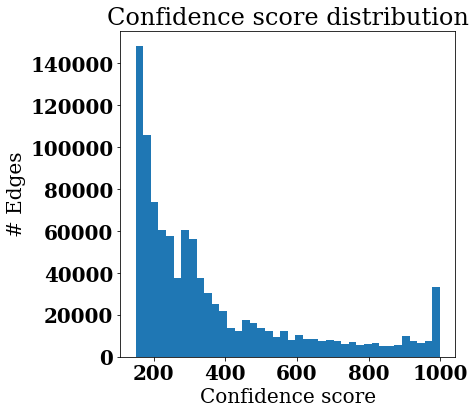

In [2]:
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("./4932.protein.links.v11.5.txt",comments="#",nodetype=str)

# For interest, plot the distribution of confidence scores
plt.figure(figsize=(6,6));
full_edges = G0.edges()
these_weights = [G0[u][v]['weight'] for u,v in full_edges]

plt.hist(these_weights, bins=40);
plt.title("Confidence score distribution")
plt.xlabel("Confidence score")
plt.ylabel("# Edges")
plt.show();

# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 700;
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);

In [3]:
# we read the provided 'essential protein' list. Should we be removing these now? TODO

import csv

# This is the variable that will store the protein names. 
# Note that this does not have the leading "4932."... maybe we should add it? Or trim it off everything else? TODO
ess_list = []; 

with open('essential_proteins.csv', newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])

#print(ess_list);

In [4]:
# Run the Louvain community finding algorithm on the giant subgraph
communities = nx_comm.louvain_communities(G)
print("We have found", len(communities), "communities")

We have found 14 communities


In [5]:
# The protein of interest
this_protein = '4932.YCR072C';
# The community containing the protein of interest
protein_comm = {'',};

# Search for the community containing the protein of interest
for c in range(len(communities)):
    if (this_protein in communities[c]): 
        print(this_protein, "is in community c =", c)
        #print("which consists of:", communities[c])
        #print()
        protein_comm = communities[c];

4932.YCR072C is in community c = 6


Graph with 389 nodes and 17510 edges
protein  YCR072C is at index 288
Distances range from  0 to 5


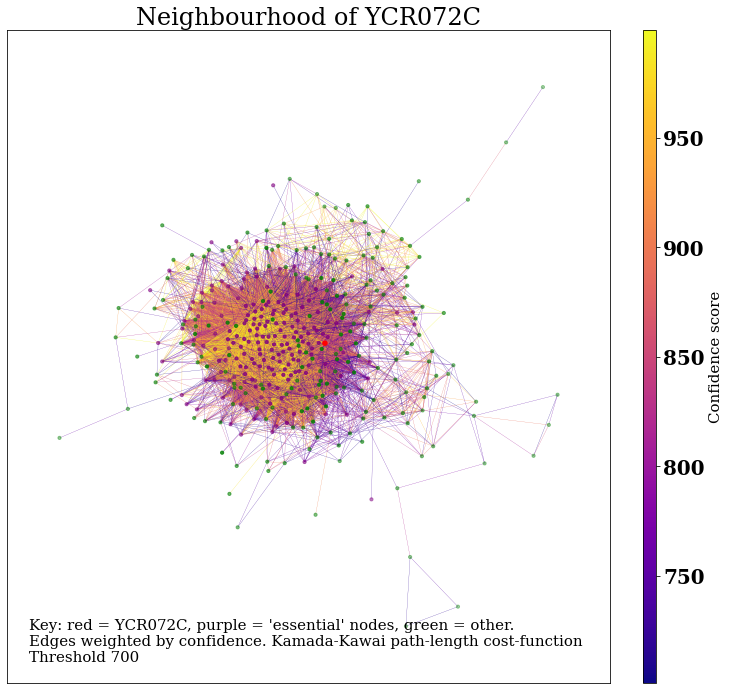

In [6]:
# A simple QoL function to cut down a network to a given nodelist
def cutdown_network(graph, nodelist):
    graph_copy = graph.copy(); # just to allow modification
    nodes_to_remove = set(graph.nodes) - protein_comm;
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

# My custom drawing function, with all my prefered defaults set. Useful general functions like this should probably be broken
# out into their own documents-to-be-included.
def my_draw(graph, with_labels=False, kkl=False, color_by_weight=True, node_color="Blue", node_size=10, alpha=0.8,
            key_text=None, title_text=None):
    # "make a new figure"
    network_fig = plt.figure(figsize=(12,12))
    # Pick the layout option. At the moment I just have KK or spring. KK is much more time-intensive.
    if (kkl):
        my_layout = nx.kamada_kawai_layout(graph, weight=None);
    else:
        my_layout = nx.spring_layout(graph, k=0.5);
    # We will almost always want to color by weight... if only 'cause it is prettier!
    if (color_by_weight):
        edges = graph.edges()
        weights = [graph[u][v]['weight'] for u,v in edges]
        # Pick the colormap here if you like!
        cmap=plt.cm.plasma;
    
        nx.draw_networkx_nodes(graph, pos=my_layout, node_size=node_size, alpha=alpha, node_color=node_color)
        nx.draw_networkx_edges(graph, pos=my_layout, edge_color=weights, edge_cmap=cmap, width=0.2)

        # Adding a colorbar as per https://stackoverflow.com/questions/26739248/how-to-add-a-simple-colorbar-to-a-network-graph-plot-in-python
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
        sm._A = [];
        cb = plt.colorbar(sm, aspect=50, fraction=0.05);
        cb.set_label("Confidence score", fontsize=15);
    else:
        # If not coloring by weight... (I really haven't worked to make this that nice though!)
        nx.draw(graph, pos=my_layout, node_size=node_size, alpha=alpha, node_color=node_color, font_size='10',with_labels=False)
    # Title, and text in bottom left
    if (key_text is not None):
        network_fig.text(0.15,0.15, key_text, fontsize=15, fontweight='light')
    if (title_text is not None):
        plt.title(title_text);
    # "show the figure"
    plt.show();
    

# Take the network of just the community of the protein of interest
protein_comm_network = cutdown_network(G, protein_comm)

print(protein_comm_network)

# ------------------------------------------------------------------------------------------------------------ #
# NODE COLORING!                                                                                               #
# This is some looping to make the pretty colors for the nodes. I wish this could be modulised better... TODO! #
# ------------------------------------------------------------------------------------------------------------ #
index_of_protein = list(protein_comm_network.nodes).index(this_protein);
print('protein ', this_protein[5:], 'is at index', index_of_protein);
num_nodes = len(protein_comm_network.nodes);
this_node_list = list(protein_comm_network.nodes);

my_colors = [];
my_sizes = [];
my_alpha = [];
for i in range(num_nodes):
    my_colors.append('g');
    my_sizes.append(10);
    my_alpha.append(0.8);
    
for protein in ess_list:
    if ('4932.'+protein in this_node_list):
        j = this_node_list.index('4932.' + protein);
        #print("Found essential protein", protein, "at index", j)
        my_colors[j] = 'purple';
        my_sizes[j] = 10;
        my_alpha[j] = 0.8;

# in particular, the following code can fade out more distant nodes (by path length).
alpha_by_distance = True;
# alternatively, highlight a particular shortest path length in yellow
highlight_dist = None;
        
path_lens = [];    
for i in range(num_nodes):
    path_len = nx.shortest_path_length(protein_comm_network, source=this_node_list[i], target=this_protein);
    path_lens.append(path_len);
    if (path_len == 0): continue; # just skip the case where we pick the target node itself
    if (alpha_by_distance): my_alpha[i] *= 1/path_len**0.5
    # highlight by shortest path length:
    if (highlight_dist is not None): 
        if (path_len == highlight_dist): my_colors[i] = 'yellow'

    
print("Distances range from ", min(path_lens), "to", max(path_lens))

# Highlight the protein of interest
my_colors[index_of_protein] = 'r';
my_sizes[index_of_protein] = 20;
my_alpha[index_of_protein] = 1;

# The draw function can be a simple as:
# my_draw(protein_comm_network)

# Draw the network
my_draw(protein_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha, 
        key_text="Key: red = "+this_protein[5:]+", purple = 'essential' nodes, green = other. "+
        "\nEdges weighted by confidence. Kamada-Kawai path-length cost-function \nThreshold "+str(threshold_score), 
        title_text="Neighbourhood of "+this_protein[5:])

In [13]:
# We need to somehow incorporate the 'essential' protein list.
# Georg seems to suggest purging them entirely (which we probably should do prior to community finding)
# however, we have a problem: the protein of interest is in essential protein list itself. 
print("Is", this_protein[5:], "in the essential protein list:",this_protein[5:] in ess_list)

Is YCR072C in the essential protein list: True


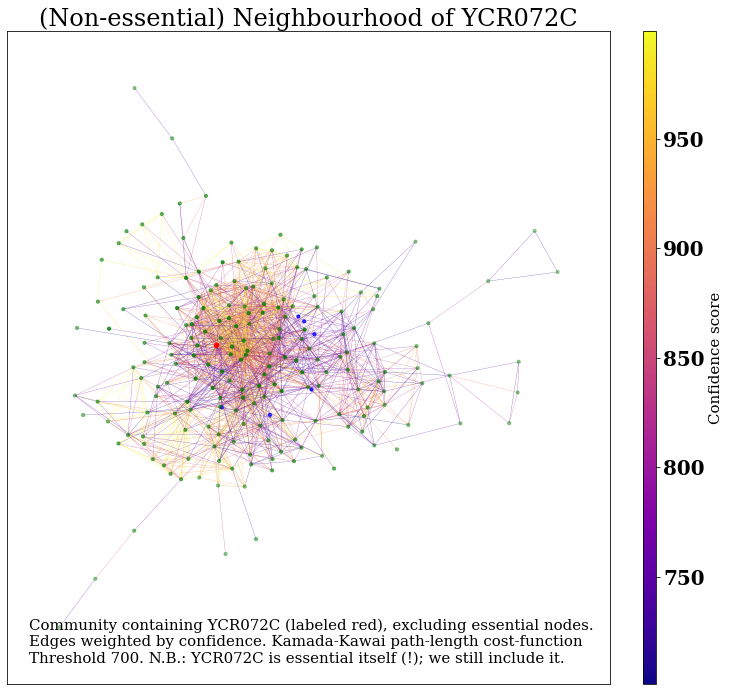

In [10]:
# WIP: please disregard.

# Let's try removing the essential nodes and plotting again:
non_ess_comm_network = protein_comm_network.copy();

# (just reiterating:)
this_node_list = list(protein_comm_network.nodes);

trimmed_ess_list = [p for p in ess_list if p != this_protein[5:]]

for ess_prot in trimmed_ess_list:
    if ('4932.'+ess_prot in this_node_list):
        non_ess_comm_network.remove_node('4932.'+ess_prot)

non_ess_index_of_protein = list(non_ess_comm_network.nodes).index(this_protein);

my_colors = [];
my_sizes = [];
my_alpha = [];

non_ess_node_list = list(non_ess_comm_network.nodes);

for i in range(len(non_ess_node_list)):
    my_colors.append('g');
    my_sizes.append(10);
    my_alpha.append(0.8);

alpha_by_distance = True;
highlight_dist = None;
        
path_lens = [];    
for i in range(len(non_ess_node_list)):
    try: 
        path_len = nx.shortest_path_length(non_ess_comm_network, source=non_ess_node_list[i], target=this_protein);
    except:
        my_colors[i] = 'blue'
        # to handle disconnect pieces. Should probably renetwork on cut-down graph?
    else:
        path_lens.append(path_len);
        if (path_len == 0): continue; # just skip the case where we pick the target node itself
        my_alpha[i] *= 1/path_len**0.5
        # highlight by shortest path length distance:
        if (highlight_dist is not None): 
            if (path_len == highlight_dist): my_colors[i] = 'yellow'    
    
my_colors[non_ess_index_of_protein] = 'r';
my_sizes[non_ess_index_of_protein] = 20;
my_alpha[non_ess_index_of_protein] = 1;

my_draw(non_ess_comm_network, kkl=True, node_color=my_colors, node_size=my_sizes, alpha=my_alpha, 
        key_text="Community containing "+this_protein[5:] + " (labeled red), excluding essential nodes. "
        "\nEdges weighted by confidence. Kamada-Kawai path-length cost-function \nThreshold "+str(threshold_score) 
        + ". N.B.: "+this_protein[5:]+" is essential itself (!); we still include it.", 
        title_text="(Non-essential) Neighbourhood of "+this_protein[5:])